# Assess in-situ cell type calling in smFISH simulation

In this step we assess the cell type calling accuracy that we can achieve in with cell expression vector identified in the smFISH simulation. This estimated accuracy can be interpret as the accuracy that would be obtained in the experiment while taking into account difficulties span by the limited number of markers and the RNA-cell assignement.  

This accuracy depend of the previous choice of the marker list and the RNA assignement method that were used. A high cell type accuracy on smFISH simulation would confirm that our marker genes and RNA assignement method are relevant to detect thetargeted cell type


#### RNA assignement error estimation

Assignement of RNA to cell is error prone in tissue due to the complexity of the cell shape, the possible high density of the nuclei and the lack of cytoplasm staining. Error in the RNA assignememnt to cell lead to error in the estimated RNA profile of the spatilly resolve cell and hence may lead to incorrect cell type calling.  
    In this notebook we start by estimation the RNA assignememnt error using the mean jaccard index (also called IoU at the molecule level). In our context the jaccard index is
$$
  \frac{GT\cap P}{GT\cup P}\
$$
Where GT is the ground truth set of RNA of the cell and P is the predicted set of RNA of the cell

In [46]:
import numpy as np
import scanpy as sc
from comseg.utils.preprocessing import run_sctransform, sctransform_from_parameters
from  sklearn.utils.random import  sample_without_replacement
from pathlib import Path
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

In [3]:
dict_result_jc = np.load("/home/tom/Bureau/phd/pipeline_review/test_set/dict_result_jc.npy", allow_pickle=True).item()

jaccard = []
for image in dict_result_jc:
    unique_cell = np.unique(dict_result_jc[image]['gr_cell'])
    for cell in unique_cell:
        df = dict_result_jc[image]
        index_gr = df[df['gr_cell'] == cell].index
        index_pred = df[df['pred_cell'] == cell].index
        intersection = len(set(index_gr).intersection(set(index_pred)))
        union = len(set(index_gr).union(set(index_pred)))
        if union != 0:
            jaccard.append(intersection / union)

print(f'mean jaccard index is {np.mean(jaccard)}')
      
      

mean jaccard index is 0.8194918686079485


The jaccard index is not equal to 1, hence estimated RNA profiles have some errors. We will try to classify theses estimated RNA profile to see if theses errors are small enought to not be detrimental for the cell type calling

#### cell type classification method
To classify each cell from its expression vector, we compute the cosine similarity between its RNA profile and the cell type centroids defined by scRNA-seq data 

We first compute the cell type centroid from the scRNA-seq data used for smFISH simulation

In [17]:
selected_gene = ['Atp6v0d2', 'Abcg1',# AM
             'Rtkn2',  'Igfbp2', #AT1
             'Sftpc','Cxcl15', #AT2,
            'Cd79a', #B_cells
             'Ms4a2', 'Fcer1a', #Basophils
             'Ccdc153', #Ciliated
             'Scgb3a2', 'Scgb1a1',#Club
             'Cst3',#DC
             'Cdh5', 'Clec14a',  #EC
             'Inmt', 'Pcolce2', # Fibroblasts
             'C1qc', 'C1qa', 'C1qb', # 'C3ar1', #IM
             'Upk3b',# Mesotheliocytes
             'Ifitm6','Plac8',# Monocytes
            'Ms4a4b', 'Ccl5', 'Hcst', # NK_T_cells
             'Gzma', 'Ncr1',# NK_cells
             'S100a9',# Neutrophils
             'Mmrn1',#Platelets
           'Acta2','Myh11', # SMC
             'Cd3g', 'Cd3d' #T_cells
             ]

path_to_rnaseq = "../test_set/test_anndata.h5ad"
anndata = None
normalize = True
sample_size = 3999
cell_type_column = "cell_ID"
random_state= 1
debug_path = None

#todo implement the function without ssam package
print('optimisation can ba done here compute sctransform and centroind only once')
if anndata is None:
    single_cells = sc.read(path_to_rnaseq)
    random_index = sample_without_replacement(len(single_cells),
                                              sample_size,
                                   random_state = random_state)
    anndata = single_cells[random_index, selected_gene].copy()
    anndata.X = anndata.X.toarray()
if type(anndata.X) != type(np.array([])):
    anndata.X = anndata.X.toarray()
#selected_genes_idx = [list(scrna_genes_qc).index(g) for g in ds.genes]
scrna_unique_clusters =np.unique(list(anndata.obs[cell_type_column]))
scrna_centroids = []
## sc transform normalize the anndata
# first remove the zero row (cell with no expression) #https://github.com/satijalab/sctransform/issues/86
zero_rows_index  = list(np.where(np.sum(anndata[:, selected_gene].X, axis=1) == 0)[0])
count_matrix = np.delete(anndata[:, selected_gene].X, zero_rows_index, axis=0)
if normalize:
    count_matrix, param_sctransform = run_sctransform(count_matrix, debug_path = debug_path)
else:
    param_sctransform  = None
#print(count_matrix.shape)
label_cell_type = np.delete(np.array(anndata.obs[cell_type_column]), zero_rows_index)

for cl in scrna_unique_clusters:
    #print(cl)
    mean = np.mean(count_matrix[label_cell_type == cl], axis=0)
    #print(mean)
    scrna_centroids.append(mean)


optimisation can ba done here compute sctransform and centroind only once
Writing temporary files...
Running scTransform via Rscript...

Attaching package: arrow

The following objects are masked from package:feather:

    read_feather, write_feather

The following object is masked from package:utils:

    timestamp

Calculating cell attributes from input UMI matrix: log_umi
Variance stabilizing transformation of count matrix of size 34 by 3996
Model formula is y ~ log_umi
Get Negative Binomial regression parameters per gene
Using 34 genes, 3996 cells
  |======================================================================| 100%
Found 2 outliers - those will be ignored in fitting/regularization step

Second step: Get residuals using fitted parameters for 34 genes
  |======================================================================| 100%
Calculating gene attributes
Wall clock passed: Time difference of 0.6580091 secs
Reading output files...
Clipping residuals...


In [42]:
y_true_cell_type  = []
y_pred_cell_type = []
for anndata_path in Path("/home/tom/Bureau/phd/pipeline_review/test_set/anndata/").glob('*h5ad'):
    print(anndata_path)
    anndata = sc.read(anndata_path)
    anndata.X = anndata.X.toarray()
    for i in range(len(anndata)):
        y_true_cell_type.append(anndata.obs['cell_type'][i])
        expression_vector = anndata.X[i]
        expression_vector = expression_vector.reshape(1, len(expression_vector))
        norm_expression_vectors = sctransform_from_parameters(
                    np.array(param_sctransform),
                    expression_vector)
        
        correlation_array = metrics.pairwise.cosine_similarity(norm_expression_vectors,
                                                                   np.array(scrna_centroids))[0]
        index_cluster_max = np.argmax(correlation_array)
        pred_rna_seq = scrna_unique_clusters[index_cluster_max]
        
        y_pred_cell_type.append(pred_rna_seq)

acc = metrics.accuracy_score(y_true=y_true_cell_type,
                             y_pred=y_pred_cell_type)
print(f"cell type accuracy{acc}")

/home/tom/Bureau/phd/pipeline_review/test_set/anndata/07_CtrlNI_Pdgfra-Cy3_Serpine1-Cy5_004.h5ad
/home/tom/Bureau/phd/pipeline_review/test_set/anndata/07_CtrlNI_Pdgfra-Cy3_Serpine1-Cy5_006.h5ad
cell type accuracy0.9402985074626866


The obtain cell type accuracy is 0.94

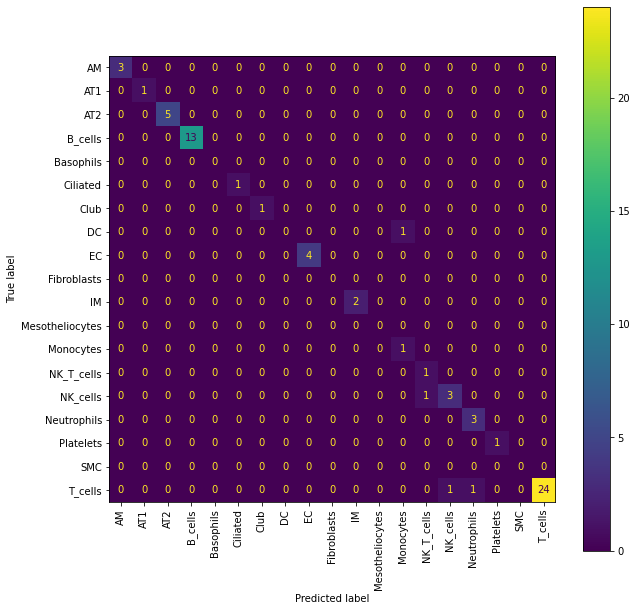

In [47]:
cm = confusion_matrix(y_true_cell_type, y_pred_cell_type, labels=scrna_unique_clusters)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=scrna_unique_clusters)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, xticks_rotation = "vertical")

the confusion matrix above give information about which cell type is miss-classified. As example, some T-cell are miss-identify as NK-cell or Neutriphilis.  

For the purpose of this tutorail we only use a very small number of cells but those notebooks can be run on larger scale.